In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# === Physical constants ===
hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
kB = 1.380649e-23     # Boltzmann constant (J/K)

In [3]:
plt.rcParams.update({
    'font.size': 16,  
    'axes.labelsize': 18,  
    'xtick.labelsize': 16,  
    'ytick.labelsize': 16,  
    'legend.fontsize': 12  
})

In [4]:
# === Power-law model ===
def power_law(T, a, n):
    return a * T**n

# === Sliding window fit of Cv = a*T^n ===
def sliding_power_law_fit(T_array, Cv_array, window=5):
    n_values = []
    T_center = []

    for i in range(window // 2, len(T_array) - window // 2):
        T_win = T_array[i - window // 2: i + window // 2 + 1]
        Cv_win = Cv_array[i - window // 2: i + window // 2 + 1]

        if len(T_win) < 2 or np.any(Cv_win <= 0):
            n_values.append(np.nan)
            T_center.append(T_array[i])
            continue

        try:
            popt, _ = curve_fit(power_law, T_win, Cv_win, p0=[1e-3, 1.0])
            _, n_fit = popt
            n_values.append(n_fit)
        except:
            n_values.append(np.nan)

        T_center.append(T_array[i])

    return np.array(T_center), np.array(n_values)

In [5]:
# === Folder structure ===
dos_folder = "DOS"
cv_folder = "Cv"
n_folder = "n"
fig_folder = "Fig"
for folder in [cv_folder, n_folder, fig_folder]:
    os.makedirs(folder, exist_ok=True)

In [6]:
# === Temperature range for calculations ===
temperatures = np.logspace(np.log10(5), 3, 1000)

In [7]:
# === Categorize input DOS files ===
dos_film_files = sorted([f for f in os.listdir(dos_folder) if f.startswith("DOS_Si_film_")],
                        key=lambda x: float(x.split('_')[-1].replace('nm.txt', '')))
dos_wire_files = sorted([f for f in os.listdir(dos_folder) if f.startswith("DOS_Si_wire_")],
                        key=lambda x: float(x.split('_')[-1].replace('nm.txt', '')))
dos_dot_files = sorted([f for f in os.listdir(dos_folder) if f.startswith("Freq_Si_dot_")],
                       key=lambda x: float(x.split('_')[-1].replace('nm.txt', '')))
dos_files = dos_film_files + dos_wire_files + dos_dot_files

In [8]:
# === Read bulk data ===
df_bulk_cv = pd.read_csv(os.path.join(cv_folder, "Cv_bulk.txt"))
T_bulk = df_bulk_cv['Temperature (K)']
Cv_bulk_NEP = df_bulk_cv['Cv_NEP (J/m3·K)']

df_bulk_n = pd.read_csv(os.path.join(n_folder, "n_bulk.txt"))
n_bulk_T = df_bulk_n['Temperature (K)']
n_bulk_NEP = df_bulk_n['n_NEP']
n_bulk_Debye = df_bulk_n['n_Debye']

In [9]:
# === Compute Cv and n(T) from DOS files ===
for dos_file in dos_film_files + dos_wire_files:
    filepath = os.path.join(dos_folder, dos_file)
    df = np.loadtxt(filepath, comments="#")
    frequencies = df[:, 0] * 1e12
    dos = df[:, 1]

    # 筛选出 dos > 0 的索引
    valid_idx = frequencies>0

    # 只保留对应的 frequencies 和 dos
    frequencies = frequencies[valid_idx]
    dos = dos[valid_idx]

    Cv_per_volume = np.zeros_like(temperatures)
    for i, T in enumerate(temperatures):
        x = hbar * frequencies / (kB * T)
        bose_factor = np.exp(-x) / (1 - np.exp(-x))**2
        integrand = dos * x**2 * bose_factor
        Cv = np.trapezoid(integrand, frequencies) * kB
        Cv_per_volume[i] = Cv

    Trange, nT_nep = sliding_power_law_fit(temperatures, Cv_per_volume, window=10)

    # Save Cv and n data
    pd.DataFrame({"Temperature (K)": temperatures, "Cv_NEP (J/m³·K)": Cv_per_volume}) \
      .to_csv(os.path.join(cv_folder, dos_file.replace("DOS", "Cv")), index=False)
    pd.DataFrame({"Temperature (K)": Trange, "n": nT_nep}) \
      .to_csv(os.path.join(n_folder, dos_file.replace("DOS", "n")), index=False)

In [10]:
# === Compute Cv and n(T) for Quantum Dots ===

dot_files = sorted([f for f in os.listdir(dos_folder) if f.startswith("Freq_Si_dot_")])

for freq_file in dot_files:
    filepath = os.path.join(dos_folder, freq_file)
    omega = np.loadtxt(filepath)  # rad/s
    omega_filtered = omega[omega > 1e-3]  # Filter out very low frequencies

    cv_list = []
    for T in temperatures:
        x = hbar * omega_filtered / (kB * T)
        bose_factor = np.exp(x) / (np.exp(x) - 1)**2
        cv_modes = kB * x**2 * bose_factor
        cv_total = np.sum(cv_modes)  # J/K
        cv_list.append(cv_total)

    dot_size_nm = float(freq_file.split('_')[-1].replace('nm.txt', ''))
    volume = (dot_size_nm * 1e-9)**3
    cv_per_volume = np.array(cv_list) / volume  # J/m³·K

    Trange, nT_nep = sliding_power_law_fit(temperatures, cv_per_volume, window=10)

    # Save Cv and n
    pd.DataFrame({"Temperature (K)": temperatures, "Cv_NEP (J/m³·K)": cv_per_volume}) \
      .to_csv(os.path.join(cv_folder, freq_file.replace("Freq", "Cv")), index=False)
    pd.DataFrame({"Temperature (K)": Trange, "n": nT_nep}) \
      .to_csv(os.path.join(n_folder, freq_file.replace("Freq", "n")), index=False)

In [11]:
# === Color maps and categories ===
colors_unified = plt.cm.Set1(np.linspace(0, 1, 5))

# === 每一类结构仍然使用自己的文件列表 ===
dos_categories = {
    'Thin film': dos_film_files,
    'Nanowire': dos_wire_files,
    'Quantum Dot': dos_dot_files,
}

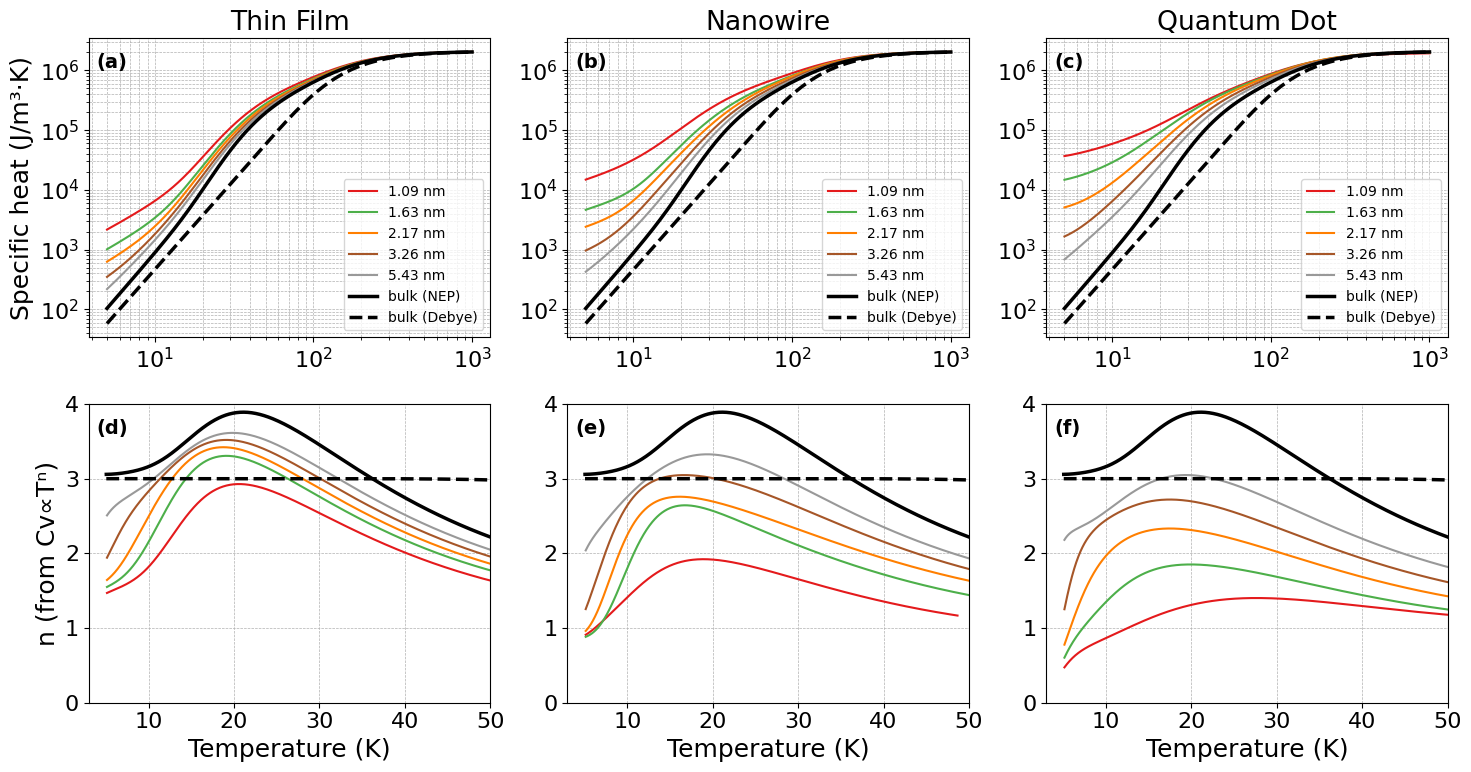

In [17]:
# === Plotting Cv, power-law n ===

fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=False)

for col, (system_name, dos_files) in enumerate(dos_categories.items()):

    for idx, dos_file in enumerate(dos_files):
        if "dot" in dos_file:
            thickness_nm = float(dos_file.split('_')[-1].replace('nm.txt', ''))
            cv_file = dos_file.replace("Freq", "Cv")
            n_file = dos_file.replace("Freq", "n")
        else:
            thickness_nm = float(dos_file.split('_')[-1].replace('nm.txt', ''))
            cv_file = dos_file.replace("DOS", "Cv")
            n_file = dos_file.replace("DOS", "n")

        df_cv = pd.read_csv(os.path.join(cv_folder, cv_file))
        df_n = pd.read_csv(os.path.join(n_folder, n_file))
        T = df_cv['Temperature (K)']
        Cv = df_cv['Cv_NEP (J/m³·K)']
        Tn = df_n['Temperature (K)']
        n_vals = df_n['n']

        axs[0, col].loglog(T, Cv, label=f'{thickness_nm:.2f} nm', color=colors_unified[idx])
        axs[1, col].plot(Tn, n_vals, color=colors_unified[idx])

    axs[0, col].loglog(T_bulk, Cv_bulk_NEP, 'k-', label='bulk (NEP)', linewidth=2.5)
    axs[0, col].loglog(T_bulk, df_bulk_cv['Cv_Debye (J/m3·K)'], 'k--', label='bulk (Debye)', linewidth=2.5)
    axs[1, col].plot(n_bulk_T, n_bulk_NEP, 'k-', linewidth=2.5)
    axs[1, col].plot(n_bulk_T, n_bulk_Debye, 'k--', linewidth=2.5)

    axs[0, col].set_title(system_name.title())

axs[0, 0].set_ylabel("Specific heat (J/m³·K)")
axs[1, 0].set_ylabel("n (from Cv∝Tⁿ)")

for i in range(2):
    for j in range(3):
        axs[i, j].grid(True, ls="--", lw=0.5, which='both')
        if i == 0:
            axs[i, j].legend(fontsize=10)

axs[1, 0].set_xlabel("Temperature (K)")
axs[1, 1].set_xlabel("Temperature (K)")
axs[1, 2].set_xlabel("Temperature (K)")

axs[1, 0].set_xlim([3, 50])
axs[1, 0].set_ylim([0, 4])
axs[1, 1].set_xlim([3, 50])
axs[1, 1].set_ylim([0, 4])
axs[1, 2].set_xlim([3, 50])
axs[1, 2].set_ylim([0, 4])

# 添加 subplot 标签
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i in range(2):
    for j in range(3):
        axs[i, j].text(0.02, 0.95, labels[i * 3 + j], transform=axs[i, j].transAxes,
                       fontsize=14, fontweight='bold', va='top', ha='left')


plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "Cv_n_relative_3x2.png"), dpi=300)
plt.show()

In [13]:
# Temperature list
T_list = [10, 20, 300]

# Load bulk cumulative data if available
bulk_cumulative_data = {}
for T_target in T_list:
    bulk_file = os.path.join(cv_folder, f"cumulative_Cv_T{T_target}K.txt")
    if os.path.exists(bulk_file):
        data = np.loadtxt(bulk_file)
        bulk_cumulative_data[T_target] = {
            'omega_bulk': data[:, 0],
            'Cv_bulk': data[:, 1],
            'omega_debye': data[:, 2],
            'Cv_debye': data[:, 3]
        }

/var/folders/mk/wgxnjlvj3bb2pkm1hwhdp4r80000gn/T/ipykernel_69560/4251954719.py:34: RuntimeWarning: divide by zero encountered in divide
  bose_factor = np.exp(x) / (np.exp(x) - 1)**2
/var/folders/mk/wgxnjlvj3bb2pkm1hwhdp4r80000gn/T/ipykernel_69560/4251954719.py:37: RuntimeWarning: invalid value encountered in multiply
  Cv_omega = x**2 * bose_factor * kB


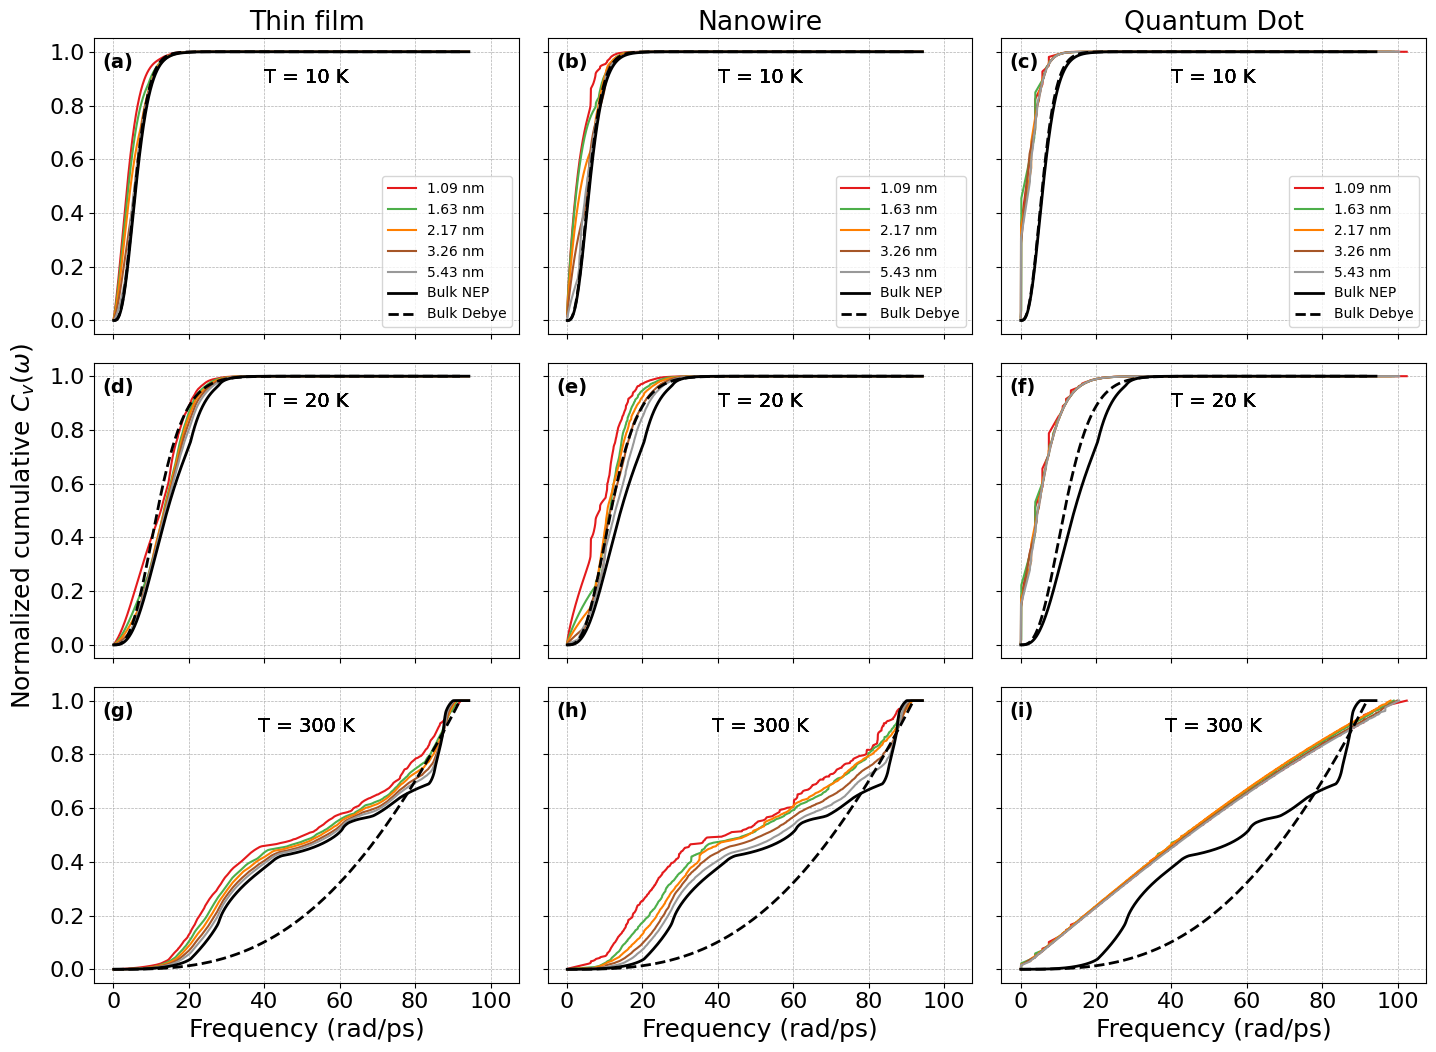

In [19]:

cv_folder = "Cv"
dos_folder = "DOS"

# File groups
dos_categories = {
    'Thin film': sorted([f for f in os.listdir(dos_folder) if f.startswith("DOS_Si_film_")],
                        key=lambda x: float(x.split('_')[-1].replace('nm.txt', ''))),
    'Nanowire': sorted([f for f in os.listdir(dos_folder) if f.startswith("DOS_Si_wire_")],
                       key=lambda x: float(x.split('_')[-1].replace('nm.txt', ''))),
    'Quantum Dot': sorted([f for f in os.listdir(dos_folder) if f.startswith("Freq_Si_dot_")],
                          key=lambda x: float(x.split('_')[-1].replace('nm.txt', '')))
}

# Plot cumulative Cv(omega) for each category
fig, axs = plt.subplots(len(T_list), 3, figsize=(15, 12), sharex=True, sharey=True)

for col, (category, files) in enumerate(dos_categories.items()):
    for row, T_target in enumerate(T_list):
        ax = axs[row, col]
        for idx_file, file in enumerate(files):
            path = os.path.join(dos_folder, file)
            data = np.loadtxt(path, comments="#")

            if "dot" in file:
                freqs = data * 1.0  # Quantum dots: already omega (rad/s)
            else:
                freqs = data[:, 0] * 1e12  # Hz → rad/s
                dos = data[:, 1]
                valid = freqs > 0
                freqs = freqs[valid]
                dos = dos[valid]

            x = hbar * freqs / (kB * T_target)
            bose_factor = np.exp(x) / (np.exp(x) - 1)**2

            if "dot" in file:
                Cv_omega = x**2 * bose_factor * kB
                volume_nm3 = float(file.split('_')[-1].replace('nm.txt', ''))**3
                Cv_omega /= (volume_nm3 * 1e-27)
                freqs = freqs[data > 1e-5]
                Cv_omega = Cv_omega[data > 1e-5]
            else:
                Cv_omega = dos * x**2 * bose_factor * kB

            Cv_cum = np.cumsum(Cv_omega * np.gradient(freqs))
            Cv_cum /= Cv_cum[-1]

            ax.plot(freqs * 1e-12, Cv_cum, label=f"{float(file.split('_')[-1].replace('nm.txt', '')):.2f} nm",
                    color=colors_unified[idx_file])
            ax.text(0.5, 0.85, f"T = {T_target} K", ha='center', transform=ax.transAxes, fontsize=14)
            
        if T_target in bulk_cumulative_data:
            bulk = bulk_cumulative_data[T_target]
            ax.plot(bulk['omega_bulk'], bulk['Cv_bulk'], 'k-', lw=2, label='Bulk NEP')
            ax.plot(bulk['omega_debye'], bulk['Cv_debye'], 'k--', lw=2, label='Bulk Debye')

        ax.set_title(category if row == 0 else "")

        ax.grid(True, ls="--", lw=0.5)
        if row == len(T_list) - 1:
            ax.set_xlabel("Frequency (rad/ps)")
        if row == 0:
            ax.legend(fontsize=10)

# 添加 subplot 标签
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
for row in range(len(T_list)):
    for col in range(3):
        axs[row, col].text(0.02, 0.95, labels[row * 3 + col],
                           transform=axs[row, col].transAxes,
                           fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.text(0.04, 0.5, "Normalized cumulative $C_v(\\omega)$", va='center', rotation='vertical', fontsize=18)
plt.savefig(os.path.join(fig_folder, "Cv_cumulative_3x4_all_structures_with_bulk.png"), dpi=300)
plt.show()

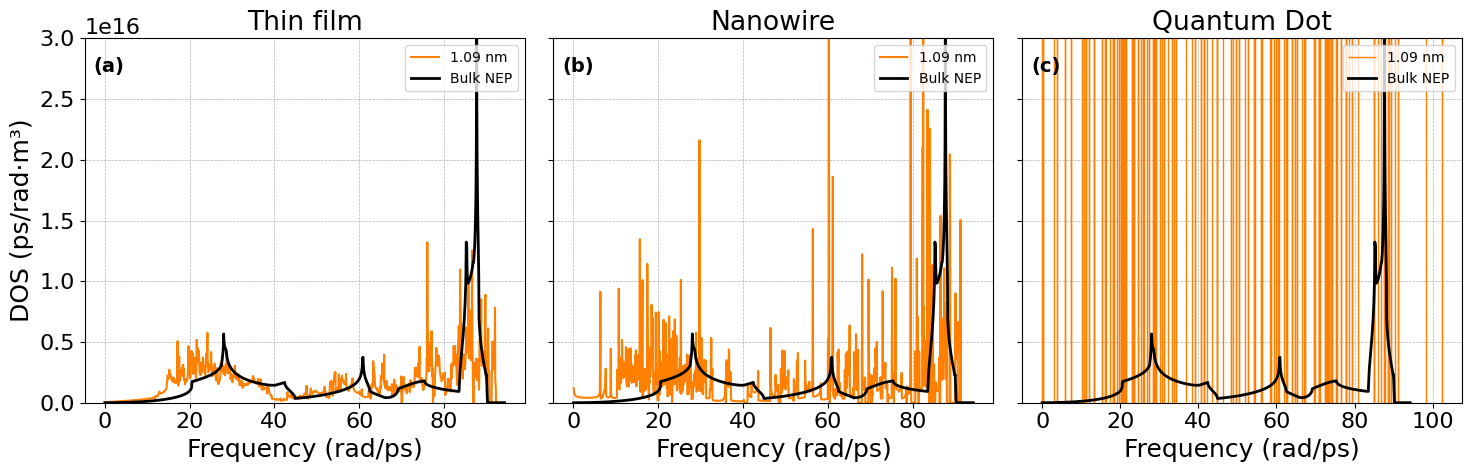

In [21]:
# === Load bulk DOS for comparison ===
bulk_dos_file = os.path.join(dos_folder, "DOS_Bulk_nep.txt")
bulk_freqs = None
bulk_dos = None
if os.path.exists(bulk_dos_file):
    df_bulk = np.loadtxt(bulk_dos_file, comments="#")
    bulk_freqs = df_bulk[:, 0] * 1e12  # Hz to rad/s
    bulk_dos = df_bulk[:, 1]

# === Plot ===
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for col, (category, files) in enumerate(dos_categories.items()):
    ax = axs[col]
    
    # 仅筛选尺寸为 1.09 nm 的文件
    selected_files = [f for f in files if "_1.09nm.txt" in f]

    for file in selected_files:
        path = os.path.join(dos_folder, file)
        data = np.loadtxt(path, comments="#")

        if "dot" in file:
            freqs = data * 1.0  # rad/s
            freqs = freqs[freqs > 1e-3]
            y_vals = np.ones_like(freqs)
            ax.vlines(freqs * 1e-12, 0, y_vals * 3e16,  # 放大视觉高度
                      label="1.09 nm",
                      color=colors_unified[2], lw=1)

        else:
            freqs = data[:, 0] * 1e12
            dos_vals = data[:, 1]
            valid = freqs > 0
            ax.plot(freqs[valid] * 1e-12, dos_vals[valid],
                    label="1.09 nm",
                    color=colors_unified[2])

    if bulk_freqs is not None and bulk_dos is not None:
        ax.plot(bulk_freqs * 1e-12, bulk_dos, 'k-', lw=2, label='Bulk NEP')

    ax.set_title(category)
    ax.set_xlabel("Frequency (rad/ps)")
    ax.grid(True, ls='--', lw=0.5)
    ax.set_ylim(0, 3e16)

axs[0].set_ylabel("DOS (ps/rad·m³)")

# 添加子图标签 (a), (b), (c)
labels = ['(a)', '(b)', '(c)']
for i in range(3):
    axs[i].text(0.02, 0.95, labels[i], transform=axs[i].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='left')

# 设置 legend 位于右上角（图内）
for ax in axs:
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "DOS_vs_frequency_3x1_selected.png"), dpi=300)
plt.show()